<center>
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="150">
</p>



<h1>Curso Procesamiento de Lenguaje Natural</h1>

<h3>El mecanismo de atención a pie</h3>


<p> Julio Waissman Vilanova </p>
<p>
<img src="https://identidadbuho.unison.mx/wp-content/uploads/2019/06/letragrama-cmyk-72.jpg" width="150">
</p>


<a target="_blank" href="https://colab.research.google.com/github/mcd-unison/pln/blob/main/labs/atencion/atencion.ipynb"><img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;"  width="30" /> Ejecuta en Colab</a>

Tomado parcialmente y adaptado de la libreta <i>C4_W1_Ungraded_Lab_1_Basic_Attention.ipynb</i> de la  <i>Especialización en procesamiento de lenguaje natural</i> de <i>Deeplearning.ai</i>, disponible en <i>Coursera</i>.

</center>


Como a estas alturas ya deberíamos haber visto en el curso, la atención permite que un modelo del tipo `seq2seq` utilice en cada paso del *decoder*, información de cada paso del *encoder* en lugar de solo el estado oculto final del codificador. 

En la operación de atención, las salidas del *encoder* se ponderan según el estado oculto del *decoder* y luego se combinan en un único vector de contexto. Este vector se utiliza luego como entrada para el decodificador y predecir el siguiente paso de salida.

En esta libreta vamos a:

- Implementar en numpy (a pie) el mecanismo de atención para ver como funciona (sin aprendizaje) tal como se propone en [el artículo original de Bhadanau, et al (2014)](https://arxiv.org/abs/1409.0473). 
  
- Implementar en numpy (a pie) el mecanismo de atención tipo **QKV** (**Q**ueries, **K**eys, **V**alues) para ver como funciona (sin aprendizaje) tal como se propone en el famoso artículo de [Attention Is All You Need](https://arxiv.org/abs/1706.03762). Desde este artículo y basado en este mecanismo de atención, los transformadores han dominado a los modelos para procesamiento de lenguaje natural.

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

Y la función *softmax* que no viene por default con numpy:

In [ ]:
def softmax(x, axis=0):
    """ Calcula la función softmax en un eje específico
    
        axis=0 calcula softmax en los renglones, cada columna de salida suma 1 
        axis=1 calcula softmax en las columnas, cada renglón de salida suma 1 
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

## El primer mecanismo de atención

### El modelo

El primer paso es calcular los puntajes de alineación. Esto es una medida de similitud entre el estado oculto del decodificador y cada estado oculto del codificador. Según el artículo, esta operación se ve así:

$$
\large e_{ij} = v_a^\top \tanh{\left(W_a s_{i-1} + U_a h_j\right)}
$$

donde $W_a \in \mathbb{R}^{n\times m}$, $U_a \in \mathbb{R}^{n \times m} $ y $v_a \in \mathbb{R}^m$ son las matrices de peso y $n$ es el tamaño del estado oculto. En la práctica, esto se implementa como una red neuronal feedforward con dos capas, donde $m$ es el tamaño de las capas en la red de alineación. Se ve algo así:

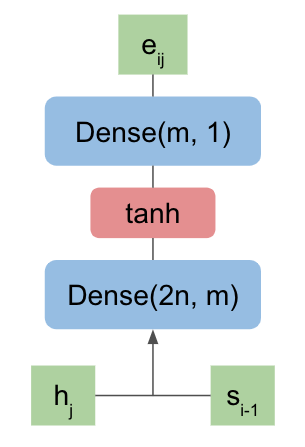

Aquí, $h_j$ son los estados ocultos del codificador para cada paso de entrada $j$ y $s_{i - 1}$ es el estado oculto del decodificador del paso anterior. La primera capa corresponde a $W_a$ y $U_a$, mientras que la segunda capa corresponde a $v_a$.

Para implementar esto, primero concatena los estados ocultos del codificador y del decodificador para producir un array con tamaño $K \times 2n$, donde $K$ es el número de estados/pasos del codificador. Para esto, utiliza `np.concatenate` ([documentación](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)). 

Ten en cuenta que solo hay un estado del decodificador, así que necesitarás remodelarlo para concatenar los arrays correctamente. La forma más fácil es usar `decoder_state.repeat` ([documentación](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html#numpy.repeat)) para que coincida con el tamaño del array de estados ocultos.

Luego, aplica la primera capa como una multiplicación de matrices entre los pesos y la entrada concatenada. Usa la función tanh para obtener las activaciones. Finalmente, realiza la multiplicación de matrices de los pesos de la segunda capa y las activaciones. Esto te dará los puntajes de alineación.

In [ ]:
hidden_size = 16
attention_size = 10
input_length = 5

# Ejemplos de dalva para probar
np.random.seed(42)
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

# Pesos usados en el mecanismo de atención. Estos se aprenden en el proceso de
# aprendizaje, pero aqui vaos a ponerlos como pesos fijos en forma pseudoaleatoria
layer_1 = np.random.randn(2 * hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

# La función de alineamiento 
# (para encontrar los pesos de las entradas en las salidas)

def alignment(encoder_states, decoder_state):
    
    # Concatena las dos entradas
    inputs = np.concatenate(
        (encoder_states, decoder_state.repeat(input_length, axis=0)), 
        axis=1
    )

    # Capa densa con activación tanh
    activations = np.tanh(inputs @ layer_1)
    
    # Capa densa con activación lineal
    scores = activations @ layer_2
    
    # fin de la red neuronal de atención
    return scores

y para probar...

In [ ]:
scores = alignment(encoder_states, decoder_state)
print(scores)

Deberíamos tener en la salida anterior:

```python
[[4.35790943]
 [5.92373433]
 [4.18673175]
 [2.11437202]
 [0.95767155]]
```

### Ponderar los vectores de salida del codificador y sumar

El siguiente paso es calcular los pesos a partir de los puntajes de alineación. Estos pesos determinan las salidas del codificador que son más importantes para la salida del decodificador. Estos pesos deben estar entre 0 y 1, y sumar 1. 

Para esto vamos a usar la función softmax que ya he implementado arriba. Los pesos te indican la importancia de cada palabra de entrada en relación con el estado del decodificador. En este paso, utilizas los pesos para modular la magnitud de los vectores del codificador. 

Las palabras con poca importancia se reducirán en comparación con las palabras importantes. Multiplica cada vector del codificador por su respectivo peso para obtener los vectores de alineación y luego suma los vectores de alineación ponderados para obtener el vector de contexto. Matemáticamente,

$$
\large c_i = \sum_{j=1}^K\alpha_{ij} h_{j}
$$

In [ ]:
def attention(encoder_states, decoder_state):
    """ Example function that calculates attention, returns the context vector 
    
        Arguments:
        encoder_vectors: NxM numpy array, where N is the number of vectors and M is the vector length
        decoder_vector: 1xM numpy array, M is the vector length, much be the same M as encoder_vectors
    """ 
    
    # Calcula el score de alignment
    scores = alignment(encoder_states, decoder_state)
    
    # Softmax
    weights = softmax(scores)
    
    # Multiplica cada estado del encoder por su peso respectivo
    weighted_scores = encoder_states * weights
    
    # Suma los pesos por los ejemplos para encontrar la salida
    context = weighted_scores.sum(axis=0)
    return context

context_vector = attention(encoder_states, decoder_state)
print(context_vector)

Si la función de `attention` se implementó correctamente, el vector de contexto debería ser:

```python
[-0.63514569  0.04917298 -0.43930867 -0.9268003   1.01903919 -0.43181409
  0.13365099 -0.84746874 -0.37572203  0.18279832 -0.90452701  0.17872958
 -0.58015282 -0.58294027 -0.75457577  1.32985756]
```



## El mecanismo de atención tipo QKV

### Obteniendo los datos para el ejemplo

El modelo  aprende cómo alinear palabras en diferentes idiomas. No se entrenarán pesos aquí, así que en su lugar vamos a usear embeddings de palabras alineadas pre-entrenadas cono las de [fasttext](https://fasttext.cc/docs/en/aligned-vectors.html). 

La siguientes celdas lo hacen a pie, pero yo te recomiendo que saltes estas primeras celdas sn ejecutar (tardan muchisimo) y utilices los archivos que obtuvimos con estas celdas:

In [ ]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.es.align.vec
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.en.align.vec

In [ ]:
en_words = {}
en_emb = None

with open("wiki.en.align.vec") as fp:
  i = 0
  for line in fp.readlines():
    line_l = line.split(' ')
    if i == 0:
      en_emb = np.zeros((int(line_l[0]), int(line_l[1])))
    else:
      en_words[line_l[0]] = i - 1
      en_emb[i - 1, :] = np.array([float(d) for d in line_l[1:]])
    i += 1

print(len(en_words))
print(en_emb)

In [ ]:
es_words = {}
es_emb = None

with open("wiki.es.align.vec") as fp:
  i = 0
  for line in fp.readlines():
    line_l = line.split(' ')
    if i == 0:
      es_emb = np.zeros((int(line_l[0]), int(line_l[1])))
    else:
      es_words[line_l[0]] = i - 1
      es_emb[i - 1, :] = np.array([float(d) for d in line_l[1:]])
    i += 1

print(len(es_words))
print(es_emb)

In [ ]:
np.save("en_emb", en_emb)
np.save("es_emb", es_emb)

with open('en_words.pickle', 'wb') as fp:
    pickle.dump(en_words, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('es_words.pickle', 'wb') as fp:
    pickle.dump(es_words, fp, protocol=pickle.HIGHEST_PROTOCOL)

Para evitar ejecutar esto (no corre en colab si no tienes la versión pro, por falta de RAM), puede descargar directamente los archivos ya transformados [desde mi espacio de *One Drive* de la Universidad de Sonora](https://unisonmx-my.sharepoint.com/:f:/g/personal/julio_waissman_unison_mx/EhtLxLcVuZFHizfT3bFR8zABKw7Lxz3Bow8JtoRwl1NtQA?e=C6Bx6L).

No hay manera sencilla de automatizar la descarga de *One Drive*, así que los tendrás que bajar a mano y ponerlos en el mismo repositorio donde estás ejecutando la libreta. Con todo es la forma más rápida.

Si tienes los archivos `npz` y `pickle` correspondientes, entonces simplemente: 

In [ ]:
# Carga los diccionarios word2idxs
with open('en_words.pickle', 'rb') as fp:
    en_words = pickle.load(fp)

with open('es_words.pickle', 'rb') as fp:
    es_words = pickle.load(fp)
    
with open('en_emb.npy', 'rb') as fp:
    en_emb = np.load(fp)
    
with open('es_emb.npy', 'rb') as fp:
    es_emb = np.load(fp)
    
print(f"La forma de en_emb es un ndarray de forma {en_emb.shape}")
print(f"La forma de es_emb es un ndarray de forma {es_emb.shape}")
print(f"es_words es un diccionario de dimensión {len(es_emb)} cuyas claves son indices y los valores tokens")
print(f"es_words es un diccionario de dimensión {len(en_emb)} cuyas claves son indices y los valores tokens")


### Preprocesamiento de datos

Vamos a usar una función para convertir una sentencia a una lista de tokens (palabras), y otra para convertir los tokens en embeddings, de acuerdo al embedding e indice elegido.

In [ ]:
def tokenize(sentence, token_mapping):
    tokenized = []
    
    for word in sentence.lower().split(" "):
        tokenized.append(token_mapping.get(word, -1))
        
    return tokenized

def embed(tokens, embeddings):
    embed_size = embeddings.shape[1]
    
    output = np.zeros((len(tokens), embed_size))
    for i, token in enumerate(tokens):
        if token == -1:
            output[i] = np.zeros((1, embed_size))
        else:
            output[i] = embeddings[token]
            
    return output

### El mecanismo de atención tipo QKV

La atención por producto punto escalado consiste en dos multiplicaciones de matrices y una escala softmax, como se muestra en el diagrama a continuación de [Vaswani, et al. (2017)](https://arxiv.org/abs/1706.03762). Toma tres matrices de entrada: las consultas (queries), las claves (keys) y los valores (values).

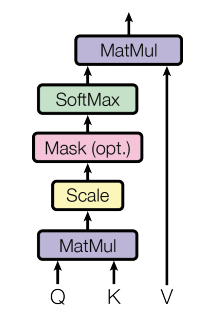

Matemáticamente, esto se expresa como

$$ 
\large \mathrm{Atención}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$

donde $Q$, $K$ y $V$ son las matrices de consultas (query), claves (key) y valores (values) respectivamente, y $d_k$ es la dimensión de las claves. En la práctica, Q, K y V tienen todas las mismas dimensiones. Esta forma de atención es más rápida y eficiente en espacio, ya que consta solo de multiplicaciones de matrices en lugar de una capa de alimentación adelante aprendida.

Conceptualmente, la primera multiplicación de matrices es una medida de la similitud entre las consultas y las claves. Esto se transforma en pesos usando la función softmax. Estos pesos luego se aplican a los valores con la segunda multiplicación de matrices, lo que da como resultado vectores de atención de salida. 

Típicamente, los estados del decodificador se utilizan como consultas mientras que los estados del codificador son las claves y los valores.

Para ilustrar como funciona, vamos a calcular las relaciones de pesos entre secuencia de encoder y decoder (relación entre consultas y llaves) antes de calcular los pesos:  

In [ ]:
def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    # Replace None with your code.
    dot = queries @ keys.T / np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)
    
    return weights

Y vamos probando con un ejemplo la relacion entre la secuencia de entrada al encoder y de salida del decoder.

In [ ]:
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words)
embedded_en = embed(tokenized_en, en_emb)

sentence_es = "El acuerdo sobre la zona económica europea fue firmada en agosto 1992 ."
tokenized_es = tokenize(sentence_es, es_words)
embedded_es = embed(tokenized_es, es_emb)

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_es, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(alignment, cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=16);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_es.split(" "), size=16);

Y ahora si podemos ver como se reparten los pesos

In [ ]:
def attention_qkv(queries, keys, values):
    return calculate_weights(queries, keys) @ values


attention_qkv_result = attention_qkv(embedded_es, embedded_en, embedded_en)

print(f"La dimensión de los pesos obtenidos con attention_qkv es: {attention_qkv_result.shape}")

print(f"Algunos elementos de la salida de pesos son:\n{attention_qkv_result[0:2,:10]}")